In [10]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

## ARIMA

In [15]:

file_path = '../data/cleaned_final_data.csv' 
df = pd.read_csv(file_path)

### clean the frist 12 columns data
columns_to_drop = df.columns[:12].tolist() + ['Jun 2021', 'Sep 2021', 'Dec 2021', 'Jun 2022', 'Sep 2022', 'Dec 2022']
df_cleaned = df.drop(columns=columns_to_drop)

### rename 
df_cleaned = df_cleaned.rename(columns={
    'Mar 2021': '2021_average_suburb_price',
    'Mar 2022': '2022_average_suburb_price',
    'Mar 2023': '2023_average_suburb_price'
})

### drop empty and duplicates
df_no_nulls = df_cleaned.dropna()
df_no_nulls.drop_duplicates(subset='Suburb', inplace=True)

### start modeling
### combine the suburbs
suburb_time_series = df_no_nulls[['2021_average_suburb_price', '2022_average_suburb_price', '2023_average_suburb_price']]
predictions = {}

### every property 3 year prediction
for suburb in df_no_nulls['Suburb'].unique():
   
    suburb_data = suburb_time_series[df_no_nulls['Suburb'] == suburb].values.flatten()
    model = ARIMA(suburb_data, order=(1, 0, 0))
    forecast = model_fit.forecast(steps=3)
    
    predictions[suburb] = forecast


forecast_df = pd.DataFrame(predictions, index=['2024_predicted_price', '2025_predicted_price', '2026_predicted_price']).T

df_forecast = df_no_nulls.merge(forecast_df, left_on='Suburb', right_index=True)

output_file_path = '../data/forecasted_suburb_prices.csv'
df_forecast.to_csv(output_file_path, index=False)

print(f"saved into: {output_file_path}")








saved into: ../data/forecasted_suburb_prices.csv


In [16]:
from sklearn.metrics import r2_score

merged_time_series = suburb_time_series.iloc[:, 1:].mean(axis=0).values.astype(float)

model = ARIMA(merged_time_series, order=(1, 0, 0))
model_fit = model.fit()

### AIC,BIC
total_aic = model_fit.aic
total_bic = model_fit.bic

print(f"total AIC: {total_aic}")
print(f"total BIC: {total_bic}")

forecast = model_fit.forecast(steps=3)
predicted_values = model_fit.predict()

actual_values = merged_time_series

r_squared = r2_score(actual_values, predicted_values)

print(f"R²: {r_squared}")


total AIC: 5.291808027143546
total BIC: 1.3712495688233814
R²: 0.5000012318178679


/Users/qi/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/qi/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


file_path = '../data/cleaned_final_data.csv' 
df = pd.read_csv(file_path)

### select the column and rename
columns_to_drop = df.columns[:12].tolist() + ['Jun 2021', 'Sep 2021', 'Dec 2021', 'Jun 2022', 'Sep 2022', 'Dec 2022']
df_cleaned = df.drop(columns=columns_to_drop)

df_cleaned = df_cleaned.rename(columns={
    'Mar 2021': '2021_average_suburb_price',
    'Mar 2022': '2022_average_suburb_price',
    'Mar 2023': '2023_average_suburb_price'
})


df_no_nulls = df_cleaned.dropna()
df_no_nulls = df_no_nulls.drop_duplicates(subset='Suburb')


years = np.array([2021, 2022, 2023]).reshape(-1, 1)


predictions = {}

### start predicting
for suburb in df_no_nulls['Suburb'].unique():

    suburb_data = df_no_nulls[df_no_nulls['Suburb'] == suburb]
    

    price_series = suburb_data[['2021_average_suburb_price', '2022_average_suburb_price', '2023_average_suburb_price']].values.flatten()
    
    ### crime
    population_data = suburb_data[['2021 popluation', '2022 popluation', '2023 popluation']].values.flatten()
    crime_data = suburb_data[['2021crime', '2022crime', '2023crime']].values.flatten()
    
    ### create linear regression
    exog_data = np.column_stack((years, population_data, crime_data))
    model = LinearRegression()
    model.fit(exog_data, price_series)
    
    ### future years
    future_years = np.array([2024, 2025, 2026]).reshape(-1, 1)
    
    ### using 2023 crime data
    future_exog = np.column_stack((future_years, [population_data[-1]]*3, [crime_data[-1]]*3))
    forecast = model.predict(future_exog)
    
    predictions[suburb] = forecast

forecast_df = pd.DataFrame(predictions, index=['2024_predicted_price', '2025_predicted_price', '2026_predicted_price']).T

### merge the data
df_forecast = df_no_nulls.merge(forecast_df, left_on='Suburb', right_index=True)

#
output_path = '../data_4/model/suburb_predictions_with_regression.csv'
df_forecast.to_csv(output_path, index=False)

print("saved 'suburb_predictions_with_regression.csv'")


预测结果已保存至 'suburb_predictions_with_regression.csv'


In [102]:
### calcaulate the growth rate 
### find out the top 10 
df_24_25 = df_forecast['2025_predicted_price'] - df_forecast['2024_predicted_price']
df_25_26 = df_forecast['2026_predicted_price'] - df_forecast['2025_predicted_price']

df_forecast['2025 growth (%)'] = (df_24_25 / df_forecast['2024_predicted_price']) * 100
df_forecast['2026 growth (%)'] = (df_25_26 / df_forecast['2025_predicted_price']) * 100

tot = df_forecast['2025 growth (%)']  + df_forecast['2026 growth (%)']
df_forecast['growth'] = tot
predict_sort = df_forecast.sort_values(by='growth', ascending=False)
predict_sort[['Suburb','growth']].iloc[0:10]

,Suburb,growth
134,Horsham,19.330289
3019,Mt Eliza,19.227876
421,Benalla,16.977022
682,Wanagaratta,14.210205
12,Geelong,13.508636
1125,Newtown,12.944736
1375,Hurstbridge,12.713984
4667,Keilor,12.410424
34,Echuca,8.765047
548,Fawkner,5.117631


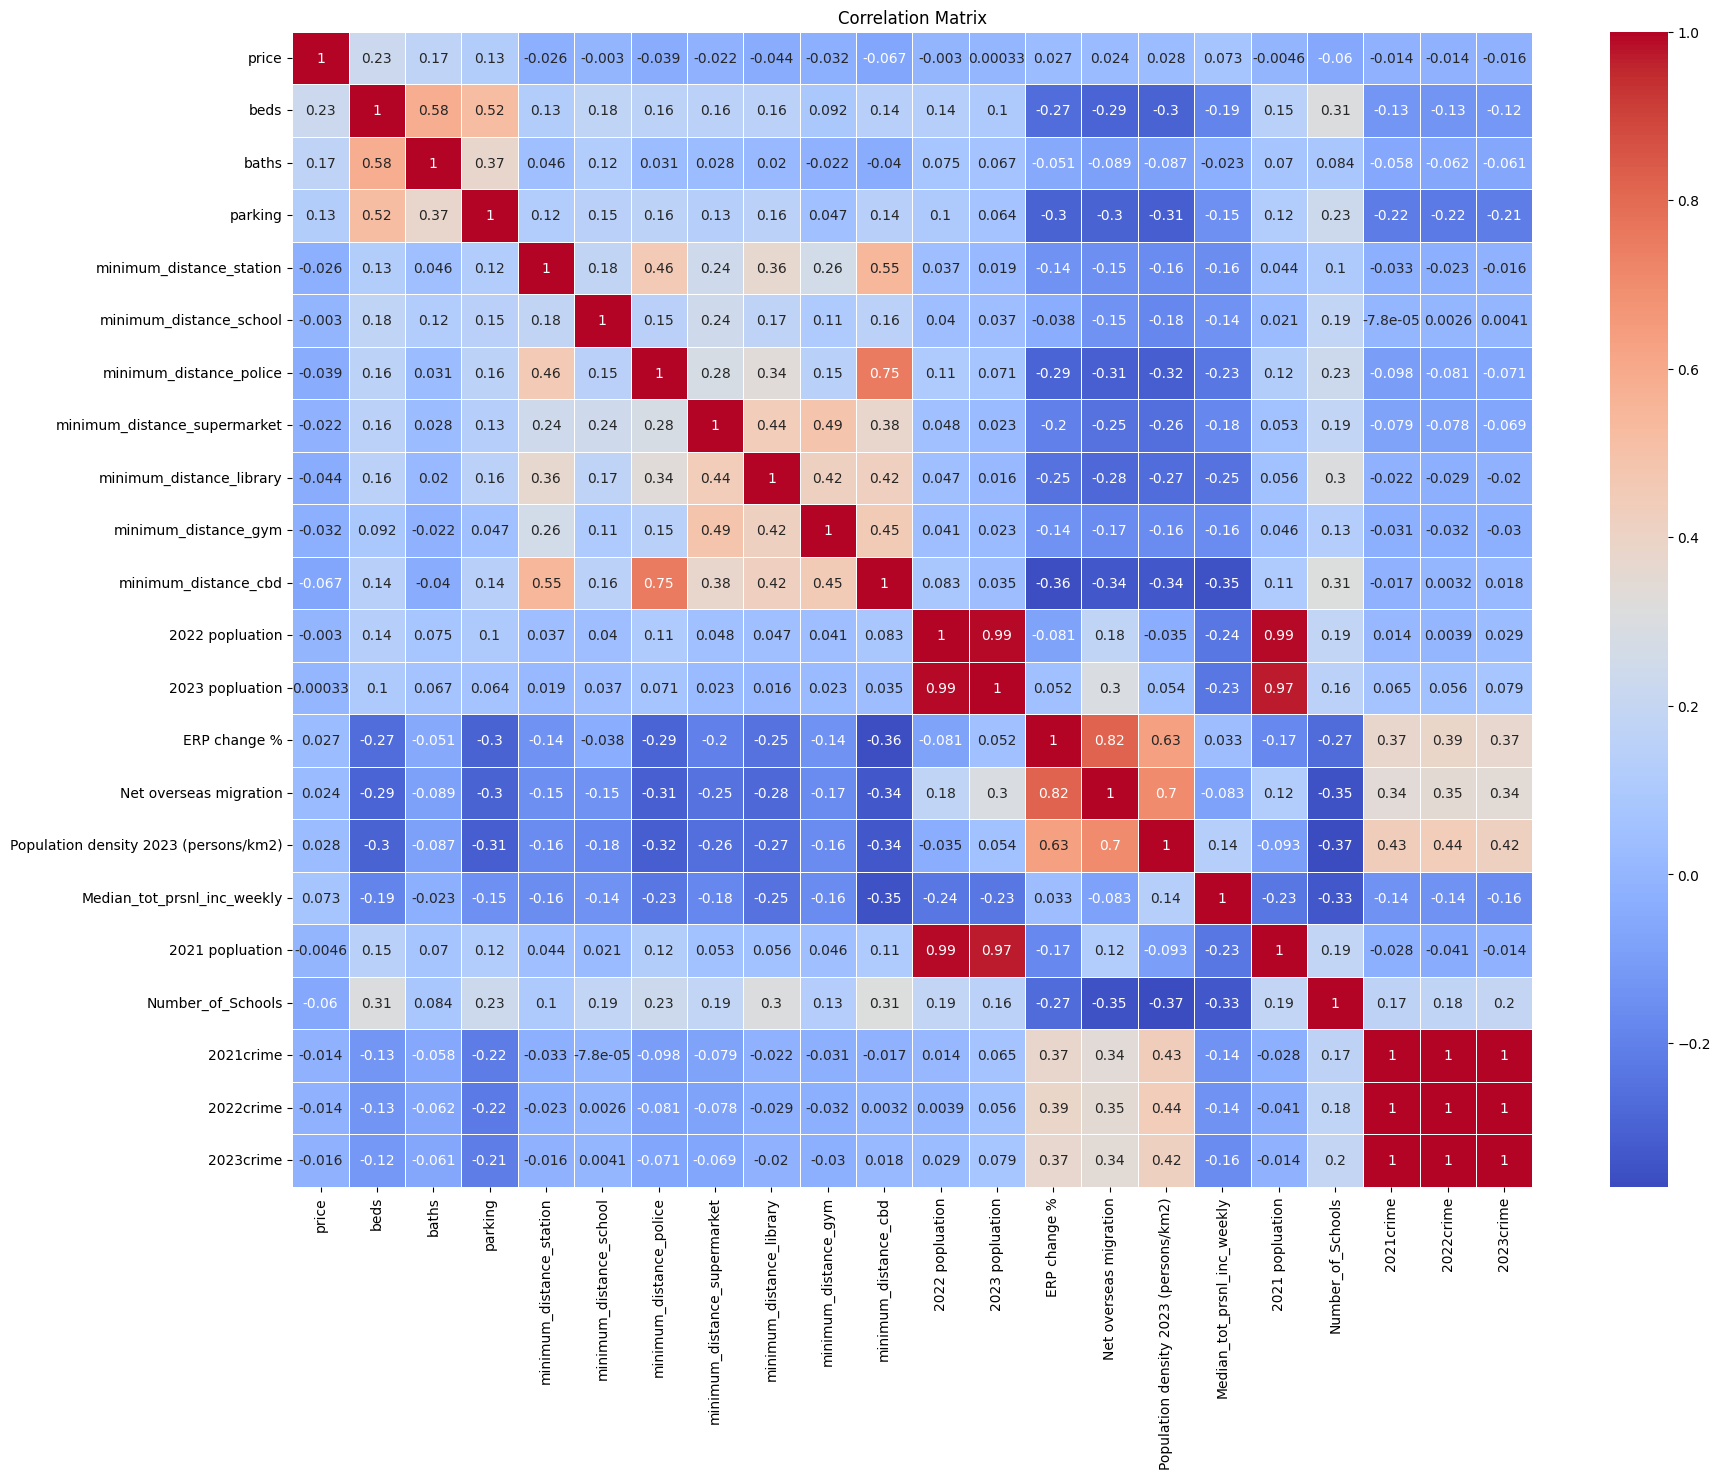

In [22]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = '../data/cleaned_final_data.csv'
df = pd.read_csv(file_path)

### remove Suburb and history price
columns_to_drop = ['Suburb', 'Mar 2021', 'Jun 2021', 'Sep 2021', 'Dec 2021', 
                   'Mar 2022', 'Jun 2022', 'Sep 2022', 'Dec 2022', 'Mar 2023']
df_cleaned = df.drop(columns=columns_to_drop)

### heat map
correlation_matrix = df_cleaned.corr(numeric_only=True)

plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


### growth rate

In [260]:
data = pd.read_csv('../data_4/model/suan/future_predicted_prices_by_suburb 0.2.csv')

In [258]:
pivot_24_25 = data['2025'] - data['2024']
pivot_25_26 = data['2026'] - data['2025']

data['2025 growth (%)'] = ( pivot_24_25 / data['2024']) * 100
data['2026 growth (%)'] = (pivot_25_26 / data['2025']) * 100

tot = data['2025 growth (%)']  + data['2026 growth (%)']
data['growth'] = tot
predict_sort = data.sort_values(by='growth', ascending=False)
predict_sort.iloc[0:10]

,Suburb,2024,2025,2026,2025 growth (%),2026 growth (%),growth
9,Ballarat,254.44635,254.44635,281.63593,0.000000,10.685781,10.685781
50,Dandenong,260.66420,288.26850,288.26850,10.589985,0.000000,10.589985
169,Werribee,264.97717,264.56244,292.16672,-0.156515,10.433938,10.277422
89,Hoppers Crossing,281.13196,280.71722,308.32150,-0.147525,9.833483,9.685958
16,Bendigo,285.24470,285.24470,312.43423,0.000000,9.532002,9.532002
74,Frankston,371.52090,379.65384,407.25806,2.189094,7.270892,9.459985
48,Cranbourne,340.07004,339.65530,367.25958,-0.121957,8.127145,8.005188
145,Shepparton,395.85312,395.43840,423.04266,-0.104766,6.980673,6.875906
150,St Albans,275.47647,275.06174,289.72610,-0.150550,5.331298,5.180748
47,Craigieburn,583.28766,579.44720,607.05145,-0.658416,4.763894,4.105478


In [272]:
import folium

# 
map_center = [-37.8136, 144.9631]  # 旧金山的经纬度
mymap = folium.Map(location=map_center, zoom_start=13)

# 准备多个地点的数据（经纬度和对应的描述）
locations = [
    {"name": "Ballarat", "coordinates": [-37.5622, 143.8503]},
    {"name": "Dandenong", "coordinates": [-37.8980, 144.6550]},
    {"name": "Werribee", "coordinates": [-37.8622, 144.6662]},
    {"name": "Hoppers Crossing", "coordinates": [-36.7570, 144.2780]},
    {"name": "Bendigo", "coordinates": [-38.1440, 145.1294]},
    {"name": "Frankston", "coordinates": [-38.0853, 145.2776]},
    {"name": "Cranbourne", "coordinates": [-38.0325, 145.3446]},
    {"name": "Shepparton", "coordinates": [-36.3805, 145.3995]},
    {"name": "St Albans", "coordinates": [-37.7584, 144.8573]},  
    {"name": "Craigieburn", "coordinates": [-37.5985, 144.9174]},     
    
]

# 在地图上为每个地点添加标记
for location in locations:
    folium.Marker(
        location["coordinates"],  # 坐标
        popup=location["name"],  # 点的名称或描述
        icon=folium.Icon(color='blue', icon='info-sign')  # 设置图标样式
    ).add_to(mymap)

# 显示地图
mymap

In [3]:
data_25 = pd.read_csv('../data_4/model/suan/future_predicted_prices_by_suburb.csv')

pivot_2425 = data_25['2025'] - data_25['2024']
pivot_2526 = data_25['2026'] - data_25['2025']

data_25['2025 growth (%)'] = ( pivot_2425 / data_25['2024']) * 100
data_25['2026 growth (%)'] = (pivot_2526 / data_25['2025']) * 100

tot_25 = data_25['2025 growth (%)']  + data_25['2026 growth (%)']
data_25['growth'] = tot_25
predict_sort_25 = data_25.sort_values(by='growth', ascending=False)
predict_sort_25.iloc[0:10]

,Suburb,2024,2025,2026,2025 growth (%),2026 growth (%),growth
74,Frankston,322.19160,383.71786,518.17883,19.096171,35.041624,54.137795
16,Bendigo,310.33926,320.36365,466.76240,3.230139,45.697678,48.927817
9,Ballarat,264.10623,290.73710,401.57544,10.083393,38.123219,48.206612
50,Dandenong,354.29736,522.47015,522.47015,47.466566,0.000000,47.466566
169,Werribee,300.44913,327.63560,449.63962,9.048610,37.237718,46.286328
8,Bairnsdale,258.69266,317.10422,391.13422,22.579520,23.345637,45.925157
150,St Albans,278.05826,308.29062,404.21840,10.872671,31.116023,41.988694
145,Shepparton,387.95374,475.40176,561.84564,22.540837,18.183332,40.724169
108,Moe,284.80573,307.57126,393.52740,7.993354,27.946740,35.940094
48,Cranbourne,334.28550,395.97617,461.94200,18.454486,16.659040,35.113526


In [269]:
import folium

# 创建地图，中心位置设定为某个点（例如[纬度, 经度]）
map_center = [-37.8136, 144.9631]  # 旧金山的经纬度
mymap = folium.Map(location=map_center, zoom_start=13)

# 准备多个地点的数据（经纬度和对应的描述）
locations = [
    {"name": "South Melbourne", "coordinates": [-37.8344, 144.9560]},
    {"name": "Bendigo", "coordinates": [-36.7570, 144.2780]},
    {"name": "Shepparton", "coordinates": [-36.3805, 145.3995]},
    {"name": "Ballarat", "coordinates": [-37.5622, 143.8503]},
    {"name": "Coburg", "coordinates": [-37.7440, 144.9647]},
    {"name": "Footscray", "coordinates": [-37.7994, 144.9023]},
    {"name": "Berwick", "coordinates": [-38.0325, 145.3446]},
    {"name": "Benalla", "coordinates": [-36.5516, 145.9843]},
    {"name": "Flemington", "coordinates": [-37.7859, 144.9299]},  
    {"name": "Noble Park", "coordinates": [-37.9700, 145.1740]},     
    
]

# 在地图上为每个地点添加标记
for location in locations:
    folium.Marker(
        location["coordinates"],  # 坐标
        popup=location["name"],  # 点的名称或描述
        icon=folium.Icon(color='blue', icon='info-sign')  # 设置图标样式
    ).add_to(mymap)

# 显示地图
mymap


In [139]:

data_ss = pd.read_csv('../data_4/model/suan/future_predicted_prices_by_suburb_svm.csv')

df_pivot = data_ss.pivot(index='Suburb', columns='year', values='predicted_price')

# re index
df_pivot.reset_index(inplace=True)

# rename
df_pivot.columns.name = None
df_pivot.columns = df_pivot.columns.astype(str)

In [122]:
pivot_24_25 = df_pivot['2025'] - df_pivot['2024']
pivot_25_26 = df_pivot['2026'] - df_pivot['2025']

df_pivot['2025 growth (%)'] = ( pivot_24_25 / df_pivot['2024']) * 100
df_pivot['2026 growth (%)'] = (pivot_25_26 / df_pivot['2025']) * 100

tot = df_pivot['2025 growth (%)']  + df_pivot['2026 growth (%)']
df_pivot['growth'] = tot
predict_sort = df_pivot.sort_values(by='growth', ascending=False)
predict_sort.iloc[0:10]


,Suburb,2024,2025,2026,2025 growth (%),2026 growth (%),growth
49,Croydon,426.012469,588.354949,588.355034,38.107448,1.429510e-05,38.107462
46,Corio,430.923562,588.355034,588.355034,36.533503,4.092575e-11,36.533503
136,Reservoir,435.413281,588.353118,588.355034,35.125212,3.255974e-04,35.125537
118,Newcombe,438.683294,588.354828,588.355034,34.118357,3.489775e-05,34.118392
150,St Albans,439.421714,588.355034,588.355034,33.893027,1.932283e-14,33.893027
126,Oak Park,440.888415,588.355025,588.355034,33.447604,1.414754e-06,33.447605
162,Traralgon,441.706596,588.344164,588.355034,33.197957,1.847521e-03,33.199805
169,Werribee,443.153383,588.355034,588.355034,32.765552,1.078214e-11,32.765552
121,Noble Park,446.335804,588.355034,588.355034,31.818919,2.318739e-13,31.818919
89,Hoppers Crossing,447.957143,588.355034,588.355034,31.341813,2.853982e-11,31.341813


### liveability and affordable

In [233]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 读取CSV文件
file_path = '../data/cleaned_final_data.csv'  
data_ = pd.read_csv(file_path)
cols_drop = ['beds','baths','parking','SA2_CODE_2021','SA2_NAME_2021','2021 popluation','2022 popluation','2023 popluation']
data_ = data_.drop(columns=cols_drop)
pp = pd.read_csv('../data_4/sa2/postcode_pop.csv')

df_1 = pd.merge(data_, pp, on='postcode',how='inner')


In [234]:
### affordability 
df_1['affordability_ratio'] = (df_1['price']  / df_1['Median_tot_prsnl_inc_weekly']*0.3)

### number of crimes per 100,000 people
df_1['crime_rate_21'] = (df_1['2021crime'] / df_1['2021 popluation']) * 100000
df_1['crime_rate_22'] = (df_1['2022crime'] / df_1['2022 popluation']) * 100000
df_1['crime_rate_23'] = (df_1['2023crime'] / df_1['2023 popluation']) * 100000
df_1['total_crime_rate'] = df_1['crime_rate_21'] + df_1['crime_rate_22'] + df_1['crime_rate_23']
df_1 = df_1.dropna()
df_1 = df_1[~df_1.isin([np.inf, -np.inf]).any(axis=1)]

In [240]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

### standardies distance 
distance_columns = ['minimum_distance_school', 'minimum_distance_police', 
                    'minimum_distance_station', 'minimum_distance_supermarket', 
                    'minimum_distance_library']
df_1[distance_columns] = scaler.fit_transform(df[distance_columns])

### get the weight 
distance_weights = {
    'minimum_distance_school': 0.2,
    'minimum_distance_police': 0.25,     
    'minimum_distance_station': 0.2,    
    'minimum_distance_supermarket': 0.15, 
    'minimum_distance_library': 0.2    
}

### standardies crime counts
df_1['total_crime_rate'] = df_1['total_crime_rate'].astype(np.float64)
df_1['total_crime_rate'] = scaler.fit_transform(df_1[['total_crime_rate']])
df_1['crime_score'] = 1 - df_1['total_crime_rate']  

### weight the crime rate
livability_score = sum(df_1[col] * weight for col, weight in distance_weights.items()) + df_1['crime_score'] * 0.25
livability_score = livability_score / (sum(distance_weights.values()) + 1)  
df_1['livability_score'] = livability_score


df_1['affordability_score'] = scaler.fit_transform(df_1[['affordability_ratio']])
df_1['affordability_score'] = 1 - df_1['affordability_score']  

df_1['combined_score'] = (df_1['livability_score']* 0.5 + df_1['affordability_score'] * 0.5)

df_1.to_csv('../data_4/model/combine_score.csv')

### get top 10
top_10 = df_1.sort_values(by='combined_score', ascending=False)
top_10 = top_10.drop_duplicates('Suburb')
top_10[['Suburb', 'livability_score','affordability_score', 'combined_score']].iloc[0:10]

,Suburb,livability_score,affordability_score,combined_score
135,Melbourne,0.345525,0.996350,0.670938
972,South Melbourne,0.346523,0.994969,0.670746
879,Geelong,0.339950,0.997447,0.668699
5449,Craigieburn,0.332844,0.994827,0.663835
2943,South Yarra,0.287723,0.998208,0.642965
5290,Port Melbourne,0.281201,0.996916,0.639058
1917,Coburg,0.282976,0.994323,0.638650
1508,Malvern East,0.283332,0.993691,0.638512
1145,Ballarat,0.279663,0.997072,0.638368
2440,Box Hill,0.285333,0.990837,0.638085
